In [1]:
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,sklearn,tensorflow

CPython 3.5.6
IPython 7.7.0

numpy 1.15.2
sklearn 0.20.0
tensorflow 1.14.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-58-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]
sound_data = np.load('urban_sound_train.npz')
X_data = sound_data['X']
y_data = sound_data['y']
groups = sound_data['groups']
X_data.shape, y_data.shape, groups.shape

((6914, 193), (6914, 10), (6914, 1))

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in gss.split(X_data, y_data, groups=groups):
    X_train = X_data[train_idx]
    y_train = y_data[train_idx]
    groups_train = groups[train_idx]

    X_val = X_data[val_idx]
    y_val = y_data[val_idx]
    groups_test = groups[val_idx]

len(X_train), len(X_val), len(y_train), len(y_val)

(5625, 1289, 5625, 1289)

In [5]:
X_train.shape, y_train.shape

((5625, 193), (5625, 10))

In [6]:
np.intersect1d(groups_train, groups_test)

array([], dtype=float64)

In [11]:
training_epochs = 10000
n_dim = 193
n_classes = 10
learning_rate = 0.01

In [12]:
g1 = tf.Graph()
with g1.as_default():
    X = tf.placeholder(tf.float32, [None, n_dim])
    Y = tf.placeholder(tf.float32, [None, n_classes])

    c1 = tf.layers.conv2d(tf.reshape(X, [-1, 1, n_dim, 1]), 50, (1, 5), padding='same', 
                          activation=tf.nn.sigmoid, name="c1")
    p1 = tf.layers.max_pooling2d(inputs=c1, pool_size=[1, 2], strides=2)
    c2 = tf.layers.conv2d(tf.reshape(p1, [-1, 1, 96, 50]), 100, (1, 5), padding='same', 
                          activation=tf.nn.sigmoid, name="c2")
    p2 = tf.layers.max_pooling2d(inputs=c2, pool_size=[1, 2], strides=2)

    h_p = tf.reshape(p2, [-1, 48*100])

    h_1 = tf.layers.dense(inputs=h_p, units=1000, activation=tf.nn.sigmoid,
                          kernel_initializer=tf.contrib.layers.xavier_initializer(), name="fc1")

    y_hat = tf.layers.dense(inputs=h_1, units=n_classes,
                            kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                            name="h4")

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=y_hat))

    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Validation accuracy:  0.064
Last cost:  2.252


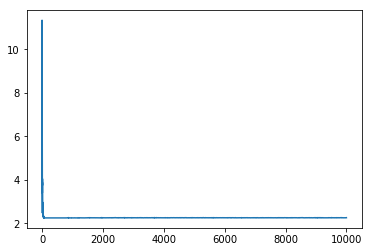

In [13]:
cost_history = []
with tf.Session(graph=g1) as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        _, cost = sess.run([optimizer, loss], feed_dict={X: X_train, Y: y_train})
        cost_history.append(cost)
    
    print('Validation accuracy: ', round(sess.run(accuracy, feed_dict={X: X_val, Y: y_val}) , 3))
    print('Last cost: ', round(cost_history[-1], 3))
plt.plot(cost_history)

Last cost:  2.251


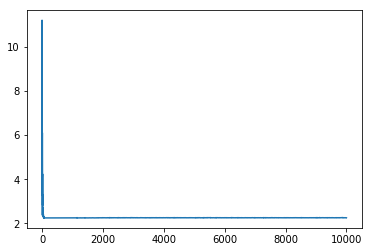

In [14]:
cost_history = []
sess = tf.Session(graph=g1)
tf.reset_default_graph()
sess.run(init)
for epoch in range(training_epochs):
    _, cost = sess.run([optimizer, loss], feed_dict={X: X_data, Y: y_data})
    cost_history.append(cost)
    
print('Last cost: ', round(cost_history[-1], 3))
plt.plot(cost_history)
saver.save(sess, "model_adam.ckpt")
sess.close()